# **Libraries**

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **One time execution**

In [ ]:
train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
p#!unzip -q "/content/drive/MyDrive/regression_data.zip" -d "/content/drive/MyDrive/regression_data"

# **Data Preparation**

In [21]:
image_dir = Path("/content/drive/MyDrive/regression_data/regression_data")

In [22]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name = 'Filepath').astype(str)
intensity = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name = 'Intensity').astype(np.int32)

images = pd.concat([filepaths, intensity], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [23]:
images

,Filepath,Intensity
0,/content/drive/MyDrive/regression_data/regress...,25
1,/content/drive/MyDrive/regression_data/regress...,30
2,/content/drive/MyDrive/regression_data/regress...,55
3,/content/drive/MyDrive/regression_data/regress...,25
4,/content/drive/MyDrive/regression_data/regress...,30
...,...,...
1736,/content/drive/MyDrive/regression_data/regress...,45
1737,/content/drive/MyDrive/regression_data/regress...,50
1738,/content/drive/MyDrive/regression_data/regress...,65
1739,/content/drive/MyDrive/regression_data/regress...,30


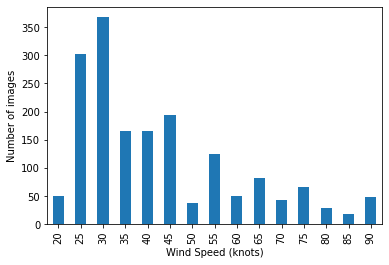

In [24]:
images.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()

In [25]:
image_df = images.sample(len(images), random_state = 1).reset_index(drop = True)
train_df, test_df = train_test_split(image_df, train_size = 0.9, shuffle = True, random_state = 1)

In [26]:
train_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, validation_split = 0.2)
test_generator = ImageDataGenerator(rescale = 1./255)

In [27]:
train_df

,Filepath,Intensity
1515,/content/drive/MyDrive/regression_data/regress...,35
1210,/content/drive/MyDrive/regression_data/regress...,45
861,/content/drive/MyDrive/regression_data/regress...,50
248,/content/drive/MyDrive/regression_data/regress...,30
810,/content/drive/MyDrive/regression_data/regress...,65
...,...,...
715,/content/drive/MyDrive/regression_data/regress...,90
905,/content/drive/MyDrive/regression_data/regress...,75
1096,/content/drive/MyDrive/regression_data/regress...,65
235,/content/drive/MyDrive/regression_data/regress...,30


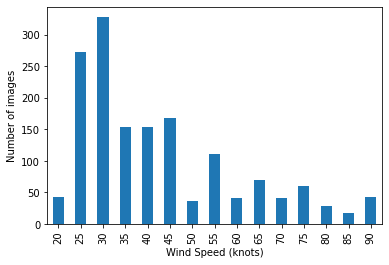

In [28]:
train_df.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()

In [29]:
width, height = 310, 310

In [30]:
train_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col = 'Filepath', y_col = 'Intensity', target_size = (width, height), class_mode = 'raw',
                                                   batch_size = 2, shuffle = True, subset = 'training')

val_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col = 'Filepath', y_col = 'Intensity', class_mode = 'raw', target_size = (width, height), 
                                                 batch_size = 1, shuffle = True, subset = 'validation')

test_images = test_generator.flow_from_dataframe(dataframe = test_df, x_col = 'Filepath', y_col = 'Intensity', class_mode = 'raw', target_size = (width, height), 
                                                 batch_size = 1, shuffle = False)

Found 1253 validated image filenames.
Found 313 validated image filenames.
Found 175 validated image filenames.


# **VGG-16**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (height, width, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'linear')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_final_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
save_at = "/content/drive/MyDrive/vgg16_regression_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'min')

In [ ]:
history = vgg16_final_model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = save_best)

Epoch 1/40
627/627 [==============================] - 1356s 2s/step - loss: 417.9849 - val_loss: 317.5312
Epoch 2/40
627/627 [==============================] - 44s 70ms/step - loss: 314.4286 - val_loss: 326.2809
Epoch 3/40
627/627 [==============================] - 42s 67ms/step - loss: 312.1581 - val_loss: 326.2953
Epoch 4/40
627/627 [==============================] - 47s 74ms/step - loss: 308.8201 - val_loss: 311.8436
Epoch 5/40
627/627 [==============================] - 41s 65ms/step - loss: 303.2388 - val_loss: 310.3727
Epoch 6/40
627/627 [==============================] - 41s 65ms/step - loss: 300.3524 - val_loss: 305.6492
Epoch 7/40
627/627 [==============================] - 39s 62ms/step - loss: 298.2684 - val_loss: 319.5644
Epoch 8/40
627/627 [==============================] - 39s 62ms/step - loss: 299.3161 - val_loss: 311.5591
Epoch 9/40
627/627 [==============================] - 44s 70ms/step - loss: 297.8471 - val_loss: 296.4515
Epoch 10/40
627/627 [=========================

In [ ]:
#vgg16_final_model.save("/content/drive/MyDrive/vgg16_regression_model.hdf5")

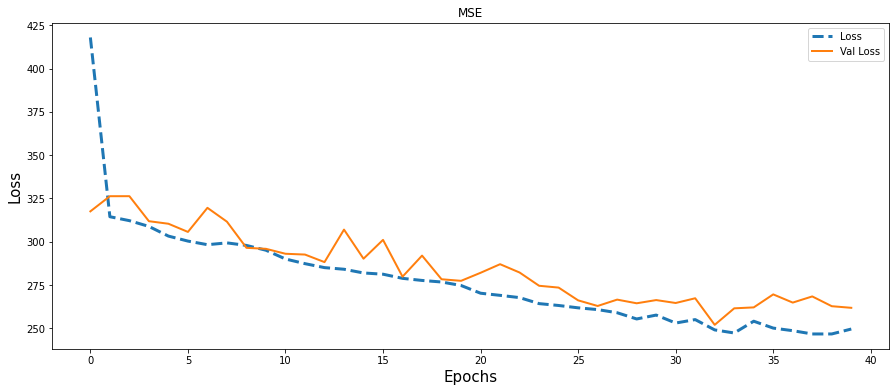

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(vgg16_final_model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(vgg16_final_model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

313/313 [==============================] - 8s 24ms/step
Validation RMSE: 16.03049
Validation R^2 Score: -0.12689


# **ResNet-50**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ResNet50_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (310, 310, 3), classes = 15)
for layers in ResNet50_model.layers:
    layers.trainable = True

# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dense(1, activation = 'linear')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_x_final_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
save_at = "/content/drive/MyDrive/resnet_regression_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'min')

In [ ]:
history = resnet50_x_final_model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = save_best)

Epoch 1/40
627/627 [==============================] - 89s 128ms/step - loss: 556.7856 - val_loss: 331.7302
Epoch 2/40
627/627 [==============================] - 59s 93ms/step - loss: 299.0870 - val_loss: 531.3605
Epoch 3/40
627/627 [==============================] - 59s 93ms/step - loss: 278.1399 - val_loss: 361.3563
Epoch 4/40
627/627 [==============================] - 59s 94ms/step - loss: 252.9764 - val_loss: 338.8516
Epoch 5/40
627/627 [==============================] - 58s 92ms/step - loss: 271.7998 - val_loss: 360.8265
Epoch 6/40
627/627 [==============================] - 67s 106ms/step - loss: 258.4814 - val_loss: 330.6311
Epoch 7/40
627/627 [==============================] - 69s 109ms/step - loss: 231.7346 - val_loss: 314.9904
Epoch 8/40
627/627 [==============================] - 68s 109ms/step - loss: 239.8211 - val_loss: 253.7127
Epoch 9/40
627/627 [==============================] - 67s 107ms/step - loss: 220.5801 - val_loss: 229.6380
Epoch 10/40
627/627 [====================

In [ ]:
#resnet50_x_final_model.save("/content/drive/MyDrive/resnet_regression_model.hdf5")

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(resnet50_x_final_model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(resnet50_x_final_model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

Validation RMSE: 12.71527
Validation R^2 Score: -0.45330


# **InceptionV3**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(1, activation = 'linear')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
InceptionV3_x_final_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
save_at = "/content/drive/MyDrive/inception_regression_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'min')

In [ ]:
history = InceptionV3_x_final_model.fit(train_images, epochs = 40, validation_data = val_images, verbose = 1, callbacks = save_best)

In [ ]:
InceptionV3_x_final_model.save('/content/drive/MyDrive/inception_regression_model.hdf5')

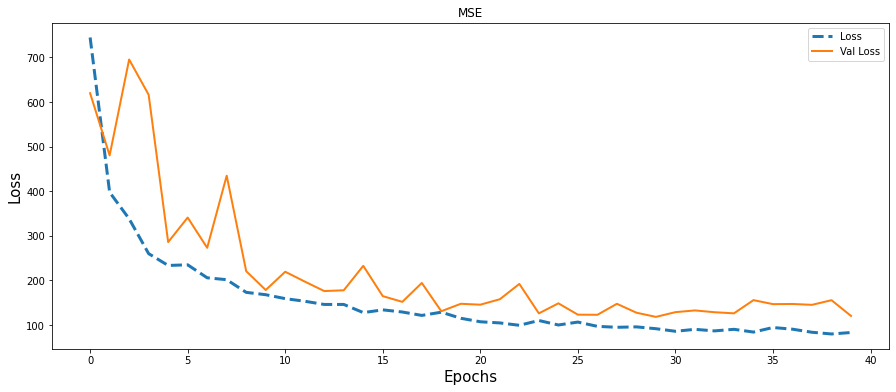

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw = 2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(InceptionV3_x_final_model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(InceptionV3_x_final_model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

Validation RMSE: 10.94465
Validation R^2 Score: -0.86259


In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(InceptionV3_x_final_model.predict(test_images))
true_intensity = test_images.labels

rmse = np.sqrt(InceptionV3_x_final_model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE: 8.79298
Test R^2 Score: 0.83538


# **XceptionNet**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(1, activation = 'linear')(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
xception_final_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
save_at = "/content/drive/MyDrive/xception_regression_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'min')

In [ ]:
history = xception_final_model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = save_best)

In [ ]:
xception_final_model.save("/content/drive/MyDrive/xception_regression_model.hdf5")

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw = 2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(xception_final_model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(xception_final_model.evaluate(val_images, verbose=0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

Validation RMSE: 22.40208
Validation R^2 Score: -1.02210


# **AlexNet**

In [31]:
tf.keras.backend.clear_session()

In [32]:
class AlexNet(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(1, activation= 'linear'))

        self.compile(optimizer= 'adam',loss='mse')

In [33]:
model = AlexNet((310, 310, 3))

In [ ]:
history = model.fit(train_images, epochs=40, validation_data=val_images, verbose=1)

Epoch 1/40
627/627 [==============================] - 1625s 3s/step - loss: 3253.6492 - val_loss: 660.2444
Epoch 2/40
627/627 [==============================] - 1655s 3s/step - loss: 422.5849 - val_loss: 324.5969
Epoch 3/40
627/627 [==============================] - 1660s 3s/step - loss: 346.5017 - val_loss: 330.8454
Epoch 4/40
171/627 [=======>......................] - ETA: 19:46 - loss: 311.8978

In [ ]:
model.save('/content/drive/MyDrive/binary_alexnet_model.hdf5')

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw = 2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(xception_final_model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(xception_final_model.evaluate(val_images, verbose=0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

# **Proposed Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (width, height, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dropout(0.4))

model.add(Dense(units = 512, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(1, activation = 'linear'))

In [ ]:
model.compile(optimizer = 'adam', loss = ['mse'])

In [ ]:
save_at = "/content/drive/MyDrive/proposed_regression_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'min')

In [ ]:
history = model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = save_best)

Epoch 1/40
627/627 [==============================] - 45s 70ms/step - loss: 408.6066 - val_loss: 320.8257
Epoch 2/40
627/627 [==============================] - 43s 69ms/step - loss: 349.2650 - val_loss: 337.6424
Epoch 3/40
627/627 [==============================] - 42s 67ms/step - loss: 345.1530 - val_loss: 322.2079
Epoch 4/40
627/627 [==============================] - 44s 70ms/step - loss: 354.6814 - val_loss: 354.4485
Epoch 5/40
627/627 [==============================] - 41s 65ms/step - loss: 348.5452 - val_loss: 341.3849
Epoch 6/40
627/627 [==============================] - 42s 68ms/step - loss: 349.2902 - val_loss: 319.9882
Epoch 7/40
627/627 [==============================] - 42s 67ms/step - loss: 346.0828 - val_loss: 322.2870
Epoch 8/40
627/627 [==============================] - 42s 67ms/step - loss: 339.2177 - val_loss: 331.7204
Epoch 9/40
627/627 [==============================] - 41s 66ms/step - loss: 340.4649 - val_loss: 553.4620
Epoch 10/40
627/627 [=========================

In [ ]:
#model.save("/content/drive/MyDrive/proposed_regression_model.hdf5")

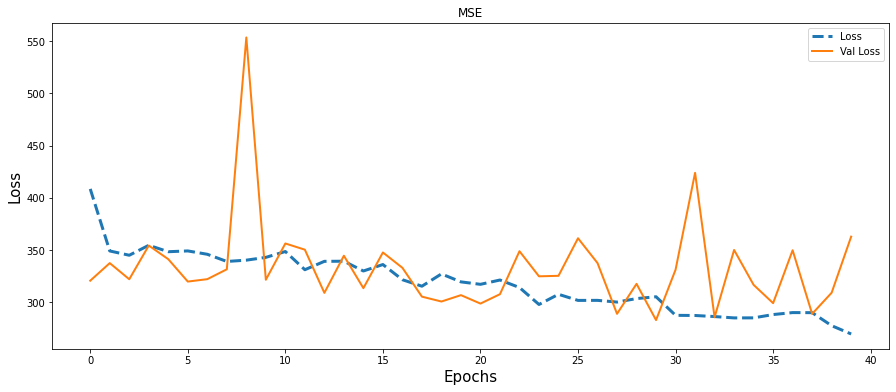

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

313/313 [==============================] - 8s 25ms/step
Validation RMSE: 18.83929
Validation R^2 Score: -0.25525


In [ ]:
print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))

Standard deviation in predicted validation intensities: 3.565612


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))

Validation MSE: 401.59


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

Validation MAE: 14.84


**Testing on the training split**

In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Test R^2 Score: {:.5f}".format(r2))

21/21 [==============================] - 0s 7ms/step
     Test RMSE: 14.66165
Test R^2 Score: -0.51436


In [ ]:
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

Test MAE: 13.46
Test MSE: 214.96


In [ ]:
null_rmse = np.sqrt(np.sum((true_intensity - np.mean(true_intensity))**2) / len(true_intensity))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 11.91428


In [ ]:
print("{0:5} {1:10}".format("True", "Predicted"))
for i in range(len(predicted_intensity[:10])):
    print("{0:5} {1:10}".format(true_intensity[i], int(predicted_intensity[i])))

True  Predicted 
   20         38
   25         45
   30         44
   30         37
   35         37
   45         38
   50         37
   55         37
   55         36
   55         38


**Testing on ASANI Cyclone**

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/cyclone_testing/test.csv')
test_df

,Filepath,Intensity
0,/content/drive/MyDrive/cyclone_testing/2022050...,20
1,/content/drive/MyDrive/cyclone_testing/2022050...,25
2,/content/drive/MyDrive/cyclone_testing/2022050...,30
3,/content/drive/MyDrive/cyclone_testing/2022050...,30
4,/content/drive/MyDrive/cyclone_testing/2022050...,35
5,/content/drive/MyDrive/cyclone_testing/2022050...,45
6,/content/drive/MyDrive/cyclone_testing/2022050...,50
7,/content/drive/MyDrive/cyclone_testing/2022050...,55
8,/content/drive/MyDrive/cyclone_testing/2022050...,55
9,/content/drive/MyDrive/cyclone_testing/2022050...,55


In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_images = test_generator.flow_from_dataframe(dataframe = test_df, x_col = 'Filepath', y_col = 'Intensity', target_size = (310, 310), class_mode = 'raw', batch_size = 1, shuffle = False)

Found 21 validated image filenames.


In [ ]:
predicted_intensity = np.squeeze(model.predict(test_images))
true_intensity = test_images.labels

21/21 [==============================] - 0s 9ms/step


In [ ]:
print('Standard deviation in predicted intensities:', np.std(predicted_intensity))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

Standard deviation in predicted intensities: 3.0814905
Test MAE: 13.46


In [ ]:
rmse = np.sqrt(model.evaluate(test_images, verbose = 0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE: 14.66165
Test R^2 Score: -0.51436


In [ ]:
print("{0:5} {1:10}".format("True", "Predicted"))
for i in range(len(predicted_intensity[:20])):
    print("{0:5} {1:10}".format(true_intensity[i], int(predicted_intensity[i])))

True  Predicted 
   20         38
   25         45
   30         44
   30         37
   35         37
   45         38
   50         37
   55         37
   55         36
   55         38
   55         34
   55         36
   55         33
   55         35
   50         37
   50         35
   45         33
   40         35
   35         40
   30         39


# **Testing using direct images**

In [ ]:
from keras.preprocessing import image

In [ ]:
binary_model = load_model('/content/drive/MyDrive/stacked_binary.hdf5')
regression_model = load_model('/content/drive/MyDrive/proposed_regression_model.hdf5')

In [ ]:
path = '/content/drive/MyDrive/cyclone_testing/20220507.00-20.jpg'
img = image.load_img(path, target_size = (310, 310))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
images = np.vstack([x])
classes = binary_model.predict(images)
if classes[0] < 0.5:
  print("\n Uploaded image doesn't have a cyclone \n")
else:
  print('Uploaded image has a cyclone')

Uploaded image has a cyclone


In [ ]:
path = '/content/drive/MyDrive/regression_data/regression_data/40/20090416.09-40.jpg'
img = image.load_img(path, target_size = (310, 310, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
images = np.vstack([x])
regression_prediction = regression_model.predict(images)
print('\nPredicted intensity of the cylone in the image :-', int(regression_prediction))


Predicted intensity of the cylone in the image :- 2004
